# scatter_plot
This is an example of all the techniques used in this folder, however all code is explicitly written here rather than using code stored in the smartfin_ride_api_v2 and double_integral_bandpass filters. (this is because we wrote this in a google colab and were too lazy to copy the modules over). We run our analysis on many smartfin rides and compare the results to heights calculated by CDIP buoys recorded during the date and time of each ride. This shows how consistent our methods are in getting a smartfin to act like a substitude buoy

In [1]:
!pip install PeakUtils
!pip install netCDF4

# imports

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import seaborn as sns

from bs4 import BeautifulSoup
from io import BytesIO
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import os
import datetime
import pytz
import peakutils
import re
import requests
import netCDF4
import datetime
import time
import requests
import random


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rc("font", size=14) 
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)



fin_url_base = 'http://surf.smartfin.org/fin/'
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote
ride_url_base = 'https://surf.smartfin.org/ride/'
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

# url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/2017%20Ride%20IDs.csv' #2017 data
url = 'https://raw.githubusercontent.com/UCSD-E4E/Smartfin/master/Ben%20Experiments/Ride_IDs_2019.csv' #2019 data
Ride_ID = pd.read_csv(url)
#for jupyter notebook
#Ride_ID = pd.read_csv('2017 Ride IDs.csv')
IDs = Ride_ID['Ride Number'].values.tolist()
print(IDs)

len(IDs)
local = False

[16380, 16376, 16345, 16318, 16302, 16301, 16300, 16299, 16298, 16297, 16290, 16289, 16278, 16262, 16253, 16252, 16250, 16249, 16243, 16239, 16238, 16237, 16225, 16222, 16221, 16212, 16211, 16197, 16196, 16195, 16192, 16191, 16189, 16178, 16177, 16175, 16173, 16171, 16169, 16168, 16167, 16161, 16160, 16158, 16152, 16148, 16140, 16137, 16135, 16134, 16128, 16126, 16115, 16106, 16103, 16101, 16100, 16099, 16098, 16088, 16081, 16079, 16076, 16075, 16073, 16072, 16000, 15996, 15983, 15980, 15978, 15972, 15963, 15962, 15953, 15945, 15859, 15858, 15857, 15856, 15854, 15848]


## query api

In [10]:
def query_ride_api(ride_ids):
    mdfs = []
    CDIP_heights = []
    times = []
    
    
    for rideId in ride_ids:
        if local:
            rideCreate =  f'http://127.0.0.1:8000/ride/ride-get/{rideId}/'
        else:
            rideCreate = f'http://ec2-54-203-7-235.us-west-2.compute.amazonaws.com/ride/rides/rideId={rideId}' # creates new ride and upload all ride data to db
        response = requests.get(rideCreate)
        print(response)
        data = response.json()
        if len(data) <= 1: 
            print('found bad ride')
            continue
        file = requests.get(f'http://ec2-54-203-7-235.us-west-2.compute.amazonaws.com/ride/rides/rideId={rideId}/dataframes/type=motion').content
        mdf = pd.read_csv(BytesIO(file))
        mdfs.append(mdf)
        CDIP_heights.append(data['heightCDIP'])
        times.append(int(data['endTime']) - int(data['startTime'])) 
        print(rideId)
        
    return mdfs, CDIP_heights, times

## data processing

In [11]:
dfs = []
times = []
CDIP_means = []
count = 0
mdfs, CDIP_means, times = query_ride_api(IDs)

<Response [200]>
16380
<Response [200]>
16376
<Response [200]>
16345
<Response [200]>
16318
<Response [200]>
16302
<Response [200]>
16301
<Response [200]>
16300
<Response [200]>
16299
<Response [200]>
16298
<Response [200]>
16297
<Response [200]>
16290
<Response [200]>
16289
<Response [200]>
16278
<Response [200]>
16262
<Response [200]>
16253
<Response [200]>
16252
<Response [200]>
16250
<Response [200]>
16249
<Response [200]>
16243
<Response [200]>
16239
<Response [200]>
16238
<Response [200]>
16237
<Response [200]>
16225
<Response [200]>
16222
<Response [200]>
16221
<Response [200]>
16212
<Response [200]>
16211
<Response [200]>
16197
<Response [200]>
16196
<Response [200]>
16195
<Response [200]>
16192
<Response [200]>
16191
<Response [200]>
16189
<Response [200]>
16178
<Response [200]>
16177
<Response [200]>
16175
<Response [200]>
16173
<Response [200]>
16171
<Response [200]>
16169
<Response [200]>
16168
<Response [200]>
16167
<Response [200]>
16161
<Response [200]>
16160
<Response [

In [12]:
dfs = mdfs
dfs

[         Timestamp    IMU A1    IMU A2     IMU A3  IMU G1  IMU G2  IMU G3  \
 0     1.576008e+09 -0.794875  0.421379   0.407014  -72.00   22.25   42.25   
 1     1.576008e+09 -0.497994 -0.411803   0.292093   60.00   51.50  -31.50   
 2     1.576008e+09 -1.211466 -0.033519  -0.047884   15.00  -45.50    2.25   
 3     1.576008e+09 -0.828394 -0.675165   0.411803  -17.75   51.50    2.75   
 4     1.576008e+09 -0.311246 -0.143652  -0.258574  -19.75   11.25    5.00   
 ...            ...       ...       ...        ...     ...     ...     ...   
 2205  1.576010e+09  2.236184 -6.454768  -8.872911  -11.00  -17.75  -19.75   
 2206  1.576010e+09  2.135628 -6.507440  -9.155427  -26.50    3.75   -6.00   
 2207  1.576010e+09  2.245761 -6.737283  -8.992621   -5.75  -52.50   85.00   
 2208  1.576010e+09  2.968810 -7.369353 -10.050859  -75.25 -128.50  220.00   
 2209  1.576010e+09  1.235408 -6.382942  -8.652645  -63.00   26.50  123.75   
 
       IMU M1  IMU M2  IMU M3  
 0     178.25 -324.75 -108.25 

In [13]:
CDIP_means

[0.7799999713897705,
 0.7250000238418579,
 0.5349999666213989,
 0.6299999952316284,
 0.39499998092651367,
 0.5299999713897705,
 0.6200000047683716,
 0.5699999928474426,
 1.1050000190734863,
 0.574999988079071,
 1.065000057220459,
 0.9399999976158142,
 0.9399999976158142,
 0.5399999618530273,
 0.8999999761581421,
 0.7649999856948853,
 0.5099999904632568,
 0.3774999976158142,
 0.8650000095367432,
 0.5119999647140503,
 0.34666669368743896,
 0.3500000238418579,
 0.5666666626930237,
 0.550000011920929,
 0.550000011920929,
 0.6399999856948853,
 0.6000000238418579,
 0.6349999904632568,
 0.675000011920929,
 0.675000011920929,
 0.9850000143051147,
 0.8299999833106995,
 0.6800000071525574,
 0.6200000047683716,
 0.48000001907348633,
 0.7724999785423279,
 0.7300000190734863,
 0.5699999928474426,
 0.6499999761581421,
 0.8350000381469727,
 0.6899999976158142,
 0.5349999666213989,
 0.49000000953674316,
 0.8033332824707031,
 0.9850000143051147,
 1.1349999904632568,
 0.49000000953674316,
 0.55500000715

In [14]:
len(times)

82

In [15]:
for df in dfs:
  print(df['IMU A2'].min())
  mean = df['IMU A2'].mean()
  std = df['IMU A2'].std()
  Upperbound = mean+(2.1*std)
  Lowerbound = mean-(2.1*std)
  Up = (mean+.5)
  Low = (mean-.5)
  print('mean is: ' + str(mean))
  print('std. dev. is: ' + str(std))
  print('Upperbound is: ' + str(Upperbound))
  print('Lowerbound is: ' + str(Lowerbound))
  df.loc[df['IMU A2'] > Upperbound, 'IMU A2'] = float(random.uniform(Up, Low))
  df.loc[df['IMU A2'] < Lowerbound, 'IMU A2'] = float(random.uniform(Up, Low))
  print(df['IMU A2'].min())

#   x2 = list(range(0, len(df)))
#   plt.plot(x2, df['IMU A2'])
#   plt.xlabel("Time [s]")
#   plt.ylabel("Acceleration [m/s^2]")
#   plt.ylim(-18,18)
#   plt.show()

-8.06367119140625
mean is: -1.68208197454891
std. dev. is: 2.905437720720163
Upperbound is: 4.419337238963433
Lowerbound is: -7.783501188061253
-7.771578588867188
-12.014103930664062
mean is: 0.04089116367560959
std. dev. is: 0.8141841272585725
Upperbound is: 1.7506778309186117
Lowerbound is: -1.6688955035673927
-1.6615759521484377
-7.953537915039062
mean is: -0.5995632677938981
std. dev. is: 1.8036600751141614
Upperbound is: 3.188122889945841
Lowerbound is: -4.387249425533637
-4.2473137451171885
-1.8674772949218743
mean is: -0.06705663026071998
std. dev. is: 0.3330154768471952
Upperbound is: 0.63227587111839
Lowerbound is: -0.7663891316398299
-0.7661445312499993
-10.05564697265625
mean is: -0.4770567431377167
std. dev. is: 1.6459674983103896
Upperbound is: 2.9794750033141013
Lowerbound is: -3.933588489589535
-3.615244506835937
-7.752424975585938
mean is: -0.38510812151631346
std. dev. is: 1.3325235679709453
Upperbound is: 2.4131913712226716
Lowerbound is: -3.183407614255299
-3.1268273

-10.117896215820313
-20.336348901367188
mean is: -3.370067891909988
std. dev. is: 6.061482319671175
Upperbound is: 9.35904497939948
Lowerbound is: -16.099180763219454
-14.65251416015625
-21.768081494140624
mean is: -1.7009049954040343
std. dev. is: 3.4882445110499907
Upperbound is: 5.624408477800946
Lowerbound is: -9.026218468609015
-8.896853369140622
-22.49591879882812
mean is: -7.712359277865416
std. dev. is: 8.474054728535338
Upperbound is: 10.083155652058792
Lowerbound is: -25.507874207789627
-22.49591879882812
-21.34861736328125
mean is: -5.33715629761442
std. dev. is: 8.383389361858464
Upperbound is: 12.267961362288354
Lowerbound is: -22.942273957517195
-21.34861736328125
-20.489577807617188
mean is: -0.6524448940918306
std. dev. is: 1.8810427627459543
Upperbound is: 3.297744907674674
Lowerbound is: -4.602634695858335
-4.127603662109375
-20.240580834960934
mean is: -2.1561943421026686
std. dev. is: 3.5036007604095087
Upperbound is: 5.201367254757301
Lowerbound is: -9.513755938962

## Calculating double integral of ride

In [16]:
## Butter Filters for Bandpass:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [17]:
def double_integral_bandpass(dacc_array, time_array, lowcut, highcut, fs, order):
    butter_lfilter = butter_bandpass_lfilter(dacc_array, lowcut, highcut, fs, order=5)

    
    #First integral is the velocity:
    v_integral = integrate.cumtrapz(x=time_array, y=butter_lfilter, initial=0)
    detrend_v_integral = signal.detrend(v_integral)
    
    v_butter_filter_integral = butter_bandpass_lfilter(detrend_v_integral, lowcut, highcut, fs, order=5)
    detrend_v_integral = signal.detrend(v_butter_filter_integral)


    #Second integral is the displacment:
    disp_integral = integrate.cumtrapz(x=time_array, y=v_butter_filter_integral, initial=0)
    detrend_disp_integral = signal.detrend(disp_integral)
    
    disp_butter_filter_integral = butter_bandpass_lfilter(detrend_disp_integral, lowcut, highcut, fs, order=5)
    detrend_disp_butter_integral = signal.detrend(disp_butter_filter_integral)
    return detrend_disp_butter_integral


def chunk_data(acc_array, time_array):
    chunk_len = 10
    times = []
    accs = []
    
        
    for i in range(int(len(acc_array) / chunk_len)):
        accs.append(acc_array[i*chunk_len:(i + 1)*chunk_len])
        times.append(time_array[i*chunk_len:(i + 1)*chunk_len])
    
    return accs, times

def filter_chunks(accs, times):
     # find threshold for chunk values
    means = []

    for chunk in accs:
        mean = chunk.mean()
        means.append(mean)

    chunk_mean = np.mean(means)
    chunk_std = np.std(means) * 2

    # find the indices of the bad chunks
    bad_chunk_indices = []

    for i in range(len(means)):
        if abs(chunk_mean - means[i]) > chunk_std:
            bad_chunk_indices.append(i)
            
    og_accs = len(accs)

    # rebuild acceleration chunk array without values from bad chunks
    accs = [i for j, i in enumerate(accs) if j not in bad_chunk_indices]
    times = [i for j, i in enumerate(times) if j not in bad_chunk_indices]
    chunks_deleted = og_accs - len(accs)
    print(f'chunks deleted: {chunks_deleted}')
        
    return accs, times

        

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy import integrate


def get_displacement(accs, times):
    fs = 5 #redefine the sampling frequency

    order=6
    lowcut = 0.09
    highcut = 1.0
    
    dacc_array = signal.detrend(accs)    

    integral = double_integral_bandpass(dacc_array, times, lowcut, highcut, fs, order)
    return integral

sig_heights = []

for df in dfs:
    accs, times = chunk_data(df['IMU A2'], df['Timestamp'])
    integrals = []
    
    accs, times = filter_chunks(accs, times)
    
    for i in range(len(accs)):
        integrals.append(get_displacement(accs[i], times[i]))
      
    displacements = []
    for integral in integrals:
        displacements.append(integral.max() - integral.min())

      
    displacements = np.sort(displacements)
    displacements = np.flip(displacements)
    third = int(len(displacements) * .33)
    sig_heights.append(displacements[0:third].mean())

chunks deleted: 0
chunks deleted: 11
chunks deleted: 20
chunks deleted: 17
chunks deleted: 25
chunks deleted: 2
chunks deleted: 23
chunks deleted: 14
chunks deleted: 19
chunks deleted: 13
chunks deleted: 16
chunks deleted: 23
chunks deleted: 24
chunks deleted: 36
chunks deleted: 41
chunks deleted: 9
chunks deleted: 30
chunks deleted: 39
chunks deleted: 22
chunks deleted: 56
chunks deleted: 9
chunks deleted: 18
chunks deleted: 32
chunks deleted: 33
chunks deleted: 31
chunks deleted: 13
chunks deleted: 15
chunks deleted: 14
chunks deleted: 21
chunks deleted: 18
chunks deleted: 19
chunks deleted: 6
chunks deleted: 24
chunks deleted: 5
chunks deleted: 10
chunks deleted: 30
chunks deleted: 19
chunks deleted: 10
chunks deleted: 17
chunks deleted: 16
chunks deleted: 15
chunks deleted: 9
chunks deleted: 21
chunks deleted: 33
chunks deleted: 36
chunks deleted: 20
chunks deleted: 20
chunks deleted: 15
chunks deleted: 11
chunks deleted: 14
chunks deleted: 17
chunks deleted: 25
chunks deleted: 14


In [18]:
#TODO: figure out the difference between these two
sig_heights

[0.2567739686189338,
 0.2801373601679927,
 0.15107878966875815,
 0.180076135459817,
 0.23821136486501474,
 0.18326423755666416,
 0.18935697138645313,
 0.1542735691458745,
 0.23601894750081373,
 0.15350147630980773,
 0.3452118962793179,
 0.30023684549574914,
 4.469101909330367,
 0.27642800688029917,
 0.28864463920527533,
 0.26693926973118376,
 0.21184246284830716,
 0.11831241057688165,
 0.25756093742882685,
 0.32507451239471824,
 0.11626191341668471,
 0.09508690001267936,
 0.18690157432189325,
 0.16196520940182066,
 0.17198283893726315,
 0.14868020270399743,
 0.18291063757257528,
 0.18734657118200015,
 1.2890052110095847,
 0.21471369435006785,
 0.19031410480193284,
 0.2062194731669194,
 0.15718228803495843,
 0.16757499868188175,
 0.21322565578879277,
 0.23319378188468332,
 0.19021670194629794,
 0.1829151847134338,
 0.15510368024526097,
 0.19180742288761982,
 0.2129383156349829,
 0.23691435213454276,
 4.120858035637523,
 0.22392937517451153,
 0.27521613651442217,
 0.28672856217052123,
 0

In [19]:
CDIP_means

[0.7799999713897705,
 0.7250000238418579,
 0.5349999666213989,
 0.6299999952316284,
 0.39499998092651367,
 0.5299999713897705,
 0.6200000047683716,
 0.5699999928474426,
 1.1050000190734863,
 0.574999988079071,
 1.065000057220459,
 0.9399999976158142,
 0.9399999976158142,
 0.5399999618530273,
 0.8999999761581421,
 0.7649999856948853,
 0.5099999904632568,
 0.3774999976158142,
 0.8650000095367432,
 0.5119999647140503,
 0.34666669368743896,
 0.3500000238418579,
 0.5666666626930237,
 0.550000011920929,
 0.550000011920929,
 0.6399999856948853,
 0.6000000238418579,
 0.6349999904632568,
 0.675000011920929,
 0.675000011920929,
 0.9850000143051147,
 0.8299999833106995,
 0.6800000071525574,
 0.6200000047683716,
 0.48000001907348633,
 0.7724999785423279,
 0.7300000190734863,
 0.5699999928474426,
 0.6499999761581421,
 0.8350000381469727,
 0.6899999976158142,
 0.5349999666213989,
 0.49000000953674316,
 0.8033332824707031,
 0.9850000143051147,
 1.1349999904632568,
 0.49000000953674316,
 0.55500000715

In [20]:
"""
calibrates the scalar to minimize error between smartfin and cdip heights (or any other heights were trying to match)
"""
def calculate_scalar(smartfin_h, CDIP_h):
    
    scalar = 1
    min_error = 10000000
    
    smartfin_h = np.array(smartfin_h)
    CDIP_h = np.array(CDIP_h)
    
    # calculate scalar to nearest whole number
    for i in range(1, 10):
        
        # calculate error of multiplying by current scalar
        heights = smartfin_h * i
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
        
        # if current scalar yields smaller error than min_error
        if error < min_error:
            scalar = i
            min_error = error
#             print(f'scalar: {scalar}')
#             print(f'error: {min_error}')
            
    # calculate scalar to nearest thousandth
    for i in range(0, 1000):
        hundredth = i / 1000
        temp_scalar = scalar + hundredth
        heights = smartfin_h * temp_scalar
        error = abs((1 - (CDIP_h/heights)) *100)
        error = np.mean(error)
#         print(f'scalar: {temp_scalar}')
#         print(f'error: {error}')
        if error < min_error:
            scalar = temp_scalar
            min_error = error
#             print(f'MIN scalar: {scalar}')
#             print(f'MIN error: {min_error}')
          
    return scalar

In [21]:
scalar = calculate_scalar(sig_heights, CDIP_means)

Scatter plot of Buoy vs. Smartfin

<class 'list'>
<class 'numpy.ndarray'>


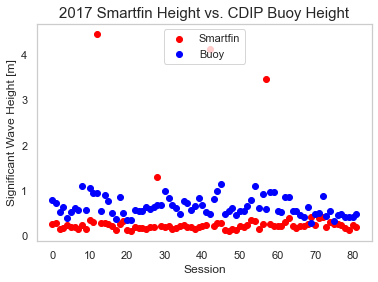

mean error is 81.55826684941458%
average difference is 0.5307789856340062 meters
average difference is 20.896821742309385 inches
length is 82


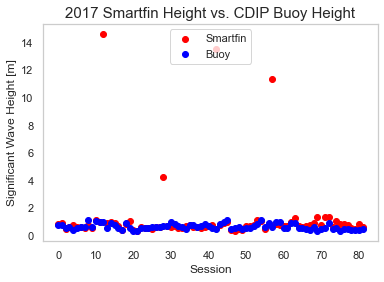

mean error is 26.105207616184522%
average difference is 0.6692718858571939 meters
average difference is 26.34930107338631 inches
length is 82


In [22]:
print(type(sig_heights))
fin = np.array(sig_heights)
print(type(fin))
buoy = np.array(CDIP_means)
fin3 = scalar*fin
data_to_plot = pd.DataFrame({'Smartfin': fin,'Buoy': buoy, 'fin_converted': fin3, 'diff1': abs(buoy-fin), 'diff2': abs(buoy-fin3)})
# data_to_plot.drop(data_to_plot[data_to_plot['diff1'] > 1].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['diff2'] > .3].index, inplace = True)
# data_to_plot.drop(data_to_plot[data_to_plot['Smartfin'] > 1].index, inplace = False)
# data_to_plot.drop(data_to_plot[data_to_plot['Buoy'] > 1.3].index, inplace = True)

x = list(range(0, len(data_to_plot)))

#Original data plot
plt.scatter(x, data_to_plot['Smartfin'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error = (abs(data_to_plot['Buoy'] - data_to_plot['Smartfin']) / data_to_plot['Buoy']) * 100
error = np.mean(error)
avgdiff1 = data_to_plot['diff1'].mean()
print('mean error is ' + str(error) + '%')
print('average difference is ' + str(avgdiff1) + ' meters')
print('average difference is ' + str(avgdiff1*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

#Converted data plot
plt.scatter(x, data_to_plot['fin_converted'], color='red')
plt.scatter(x, data_to_plot['Buoy'], color='blue')
plt.legend(['Smartfin', 'Buoy'], loc=9)
plt.xlabel('Session')
plt.ylabel('Significant Wave Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()

error3 = abs((1 - (data_to_plot['Buoy']/data_to_plot['fin_converted'])) *100)
error3 = np.mean(error3)
avgdiff2 = data_to_plot['diff2'].mean()
print('mean error is ' + str(error3) + '%')
print('average difference is ' + str(data_to_plot['diff2'].mean()) + ' meters')
print('average difference is ' + str(avgdiff2*39.3701) + ' inches')
print('length is ' + str(len(data_to_plot)))

In [23]:
scalar

3.275999999999999

Linear Regression Model

In [ ]:
# (m,b) = np.polyfit(data_to_plot['Smartfin'],data_to_plot['Buoy'],1)
yp = np.polyval([m,b],data_to_plot['Smartfin'])
equation = 'y = ' + str(round(m,4)) + 'x' ' + ' + str(round(b,4))
plt.scatter(data_to_plot['Smartfin'],data_to_plot['Buoy'], color='red')
plt.plot(data_to_plot['Smartfin'],yp)
#plt.text(1,1, equation)

plt.xlabel('Smartfin Height [m]')
plt.ylabel('CDIP Buoy Height [m]')
plt.title('2017 Smartfin Height vs. CDIP Buoy Height', size=15)
plt.grid()
plt.show()
print('Prediction is: ' + str(equation))

#Calculate R^2 value
# x = fin
# y = buoy

correlation_matrix = np.corrcoef(data_to_plot['Smartfin'], data_to_plot['Buoy'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print('R^2 value is: ' + str(r_squared))
print(len(data_to_plot))

In [ ]:
# TODO: figure out how to implement the water time cropper and also match the height analysis in the smartfin app with the one here